In this blog post, I'm going to write a short tutorial on cepstrum processing for pitch extraction. For context, I'm currently working on a [side-project that involves spectrograms](https://github.com/flothesof/pyqtgraph-spectrographer), so I'm naturally wanting to try pitch extraction (to tune my guitar, for example). In that context, I've encountered the cepstrum representation. Since I'm always willing to learn something new, the goal of this blog post is to figure things out while I go along, with the goal of extracting a pitch from a musical (voice, instrument) sound.

# What is a cepstrum?

As the name suggests, a cepstrum is related to a spectrum. But how exactly? To find out, we're going to tackle this hands-on. Let's start by generating a sinusoidal signal.

Text(0.5, 1.0, 'time signal')

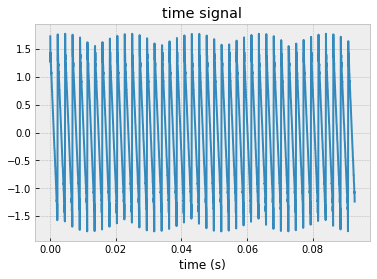

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

import numpy as np

def make_sine_wave(f0, sampling_frequency, frame_size, phase=0):
    """Generates a sine wave of frequency f0.
    
    :param f0: float, fundamental frequency
    :param sampling_frequency: int, number of samples per second
    :param frame_size: int, number of samples in frame
    :return:
        - waveform - ndarray of waveform
    """
    t = np.arange(frame_size) / sampling_frequency
    return np.sin(2 * np.pi * f0 * t + phase)


def make_harmonic_wave(f0, sampling_frequency, frame_size, n_harmonics=10):
    """Generates a 1/f weighted harmonic (multiples of f0) wave of frequency f0.
    
    :param f0: float, fundamental frequency
    :param sampling_frequency: int, number of samples per second
    :param frame_size: int, number of samples in frame
    :param n_harmonics: int, number of harmonics to add
    :return:
        - waveform - ndarray of waveform
    """
    waveform = np.zeros((frame_size,), dtype=float)
    for f in [f0 * i for i in range(1, n_harmonics + 1)]:
        waveform += f0 / f * make_sine_wave(f, sampling_frequency, frame_size, phase=f)
    return waveform

sample_freq = 22050 # Hz
frame_size = 2048
time_vector = np.arange(frame_size) / sample_freq
signal = make_harmonic_wave(440, sample_freq, frame_size, n_harmonics=20)

fig, ax = plt.subplots()
ax.plot(time_vector, signal)
ax.set_xlabel('time (s)')
ax.set_title('time signal')

If we go to Fourier space, we expect that same signal to be full of peaks.

Text(0.5, 1.0, 'Fourier spectrum')

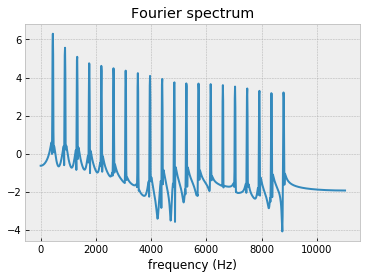

In [2]:
windowed_signal = np.hamming(frame_size) * signal
dt = 1/sample_freq
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
X = np.fft.rfft(windowed_signal)
log_X = np.log(np.abs(X))

fig, ax = plt.subplots()
ax.plot(freq_vector, log_X)
ax.set_xlabel('frequency (Hz)')
ax.set_title('Fourier spectrum')

As expected, we find 20 harmonics in the spectrum. Now the idea of the [cepstrum](https://en.wikipedia.org/wiki/Cepstrum) is that the above spectrum, in log scale, can be treated as a periodic signal itself. And in fact its periodicity, in this case, is linked to the spacing between the different peaks. 

Let's then compute and visualize the cepstrum of this spectrum.

Text(0.5, 1.0, 'cepstrum')

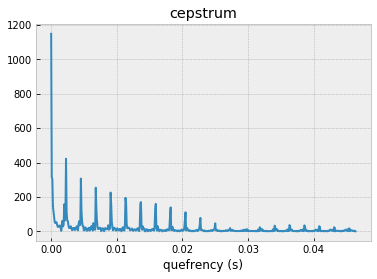

In [3]:
cepstrum = np.fft.rfft(log_X)
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(log_X.size, df)

fig, ax = plt.subplots()
ax.plot(quefrency_vector, np.abs(cepstrum))
ax.set_xlabel('quefrency (s)')
ax.set_title('cepstrum')

Now, the interesting point is that we expect a peak at a frequency of 440 Hz, hence a quefrency of 1/440 s which is approximately 0.0022 seconds.

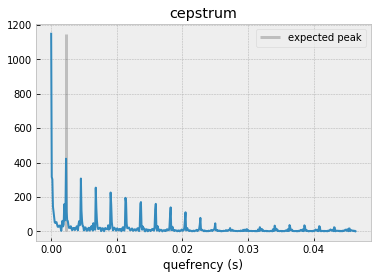

In [4]:
fig, ax = plt.subplots()
ax.vlines(1/440, 0, np.max(np.abs(cepstrum)), alpha=.2, lw=3, label='expected peak')
ax.plot(quefrency_vector, np.abs(cepstrum))
ax.set_xlabel('quefrency (s)')
ax.set_title('cepstrum')
ax.legend()

# Extracting a pitch 

However, one thing that makes a robust identificiation difficult is that there are also several other peaks, as well as a strong component at zero quefrency. This is mentioned in the 1964 paper by Noll, “Short‐Time Spectrum and ‘Cepstrum’ Techniques for Vocal‐Pitch Detection.”, who attenuates the low quefrency components, which are expected to be high since the log magnitude of the spectrum has a nonzero mean.

Hence, it is important to take into account low and high f0 frequency values to be detected. In the case of a guitar pitch tracker, pitches would be expected to range between 82 Hz and 640 Hz. This translates to quefrencies between 1/640 and 1/82 seconds.

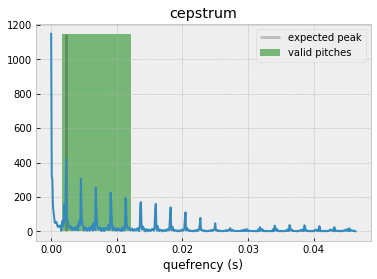

In [5]:
import matplotlib.collections as collections

fig, ax = plt.subplots()
ax.vlines(1/440, 0, np.max(np.abs(cepstrum)), alpha=.2, lw=3, label='expected peak')
ax.plot(quefrency_vector, np.abs(cepstrum))
valid = (quefrency_vector > 1/640) & (quefrency_vector <= 1/82)
collection = collections.BrokenBarHCollection.span_where(
    quefrency_vector, ymin=0, ymax=np.abs(cepstrum).max(), where=valid, facecolor='green', alpha=0.5, label='valid pitches')
ax.add_collection(collection)
ax.set_xlabel('quefrency (s)')
ax.set_title('cepstrum')
ax.legend()

Finally, we can implement a cepstrum based pitch tracker and see how well it works with our simple harmonic wave generator.

In [6]:
def compute_cepstrum(signal, sample_freq):
    """Computes cepstrum."""
    frame_size = signal.size
    windowed_signal = np.hamming(frame_size) * signal
    dt = 1/sample_freq
    freq_vector = np.fft.rfftfreq(frame_size, d=dt)
    X = np.fft.rfft(windowed_signal)
    log_X = np.log(np.abs(X))
    cepstrum = np.fft.rfft(log_X)
    df = freq_vector[1] - freq_vector[0]
    quefrency_vector = np.fft.rfftfreq(log_X.size, df)
    return quefrency_vector, cepstrum

def cepstrum_f0_detection(signal, sample_freq, fmin=82, fmax=640):
    """Returns f0 based on cepstral processing."""
    quefrency_vector, cepstrum = compute_cepstrum(signal, sample_freq)
    # extract peak in cepstrum in valid region
    valid = (quefrency_vector > 1/fmax) & (quefrency_vector <= 1/fmin)
    max_quefrency_index = np.argmax(np.abs(cepstrum)[valid])
    f0 = 1/quefrency_vector[valid][max_quefrency_index]
    return f0

Let's test this on our input signal.

In [7]:
cepstrum_f0_detection(signal, sample_freq)

441.43066406249994

# Evaluating the algorithm's performance 

With our function defined, we can do a little parametric study, for instance varying the number of harmonics, and see how the pitches are estimated.

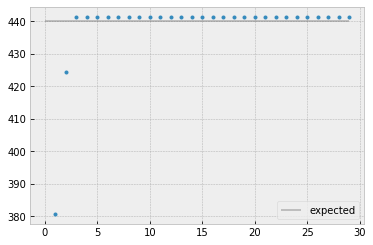

In [8]:
harmonics = np.arange(1, 30)
f0s = []
for n_harmonics in harmonics:
    signal = make_harmonic_wave(440, sample_freq, frame_size, n_harmonics)
    f0s.append(cepstrum_f0_detection(signal, sample_freq))

fig, ax = plt.subplots()
ax.hlines(440, 0, harmonics.max(), label='expected', alpha=.2)
ax.plot(harmonics, f0s, '.')
ax.legend()

As expected, due to the fact that the periodicity in the spectrum needs to be visible, a certain number of harmonics is needed to make the extraction work (here, at least three). Also, we see that the identified f0 is not super precise.

Another question we can ask is how well this works if we use a fixed number of harmonics and vary the f0 frequency.

Text(0, 0.5, 'cepstrum based f0 (Hz)')

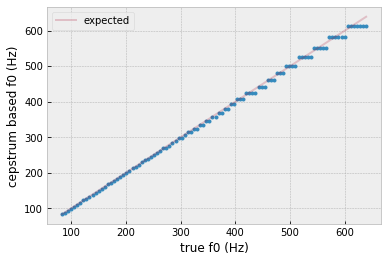

In [9]:
f0s = np.linspace(83, 639, num=100)
cepstrum_f0s = []
for f0 in f0s:
    signal = make_harmonic_wave(f0, sample_freq, frame_size, n_harmonics=10)
    cepstrum_f0s.append(cepstrum_f0_detection(signal, sample_freq))

fig, ax = plt.subplots()
ax.plot(f0s, cepstrum_f0s, '.')
ax.plot(f0s, f0s, label='expected', alpha=.2)
ax.legend()
ax.set_xlabel('true f0 (Hz)')
ax.set_ylabel('cepstrum based f0 (Hz)')

We see that the cepstrum based f0 seems to work better on low f0s than on high f0s. This is a consequence of the grid based processing from the Fourier transform. To see why, let's compare the cepstra of a low frequency pitch and of a high frequency one.

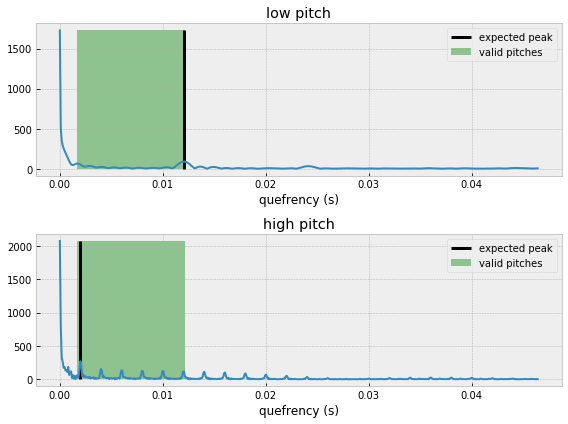

In [10]:
def plot_cepstrum(signal, sample_freq, expected_f0, ax=None):
    quefrency_vector, cepstrum = compute_cepstrum(signal, sample_freq)
    if ax is None:
        fig, ax = plt.subplots()
    ax.vlines(1/expected_f0, 0, np.max(np.abs(cepstrum)), alpha=1, lw=3, label='expected peak')
    ax.plot(quefrency_vector, np.abs(cepstrum))
    valid = (quefrency_vector > 1/640) & (quefrency_vector <= 1/82)
    collection = collections.BrokenBarHCollection.span_where(
        quefrency_vector, ymin=0, ymax=np.abs(cepstrum).max(), where=valid, facecolor='green', 
        alpha=0.4, label='valid pitches')
    ax.add_collection(collection)
    ax.set_xlabel('quefrency (s)')
    ax.legend()

low_pitch = make_harmonic_wave(83, sample_freq, frame_size)
high_pitch = make_harmonic_wave(500, sample_freq, frame_size)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6))
ax1.set_title('low pitch')
ax2.set_title('high pitch')
plot_cepstrum(low_pitch, sample_freq, 83, ax=ax1)
plot_cepstrum(high_pitch, sample_freq, 500, ax=ax2)
plt.tight_layout()

An intuitive explanation for the more accurate identifiaction of low-pitches comes from the nonlinear transformation between the index on the quefrency axis to the f0 value: taking the inverse means that a bin is a lot larger for high pitches than for low pitches. To improve resolution, we could:

- change sample frequency
- collect more samples
- do zero padding in the spectrum computation or the cepstrum computation

Let's try adding more samples to the waveform.

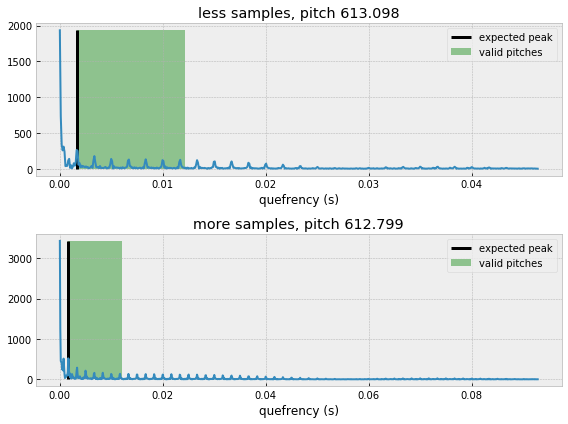

In [11]:
less_samples = make_harmonic_wave(600, sample_freq, frame_size)
more_samples = make_harmonic_wave(600, sample_freq, 2 * frame_size)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6))
ax1.set_title(f'less samples, pitch {cepstrum_f0_detection(less_samples, sample_freq):.3f}')
ax2.set_title(f'more samples, pitch {cepstrum_f0_detection(more_samples, sample_freq):.3f}')
plot_cepstrum(less_samples, sample_freq, 600, ax=ax1)
plot_cepstrum(more_samples, sample_freq, 600, ax=ax2)
plt.tight_layout()

Not really convincing. Actually, it seems that taking less samples shows a larger valid pitch region, so that is the right way to improve detection. 

What about changing the sampling frequency?

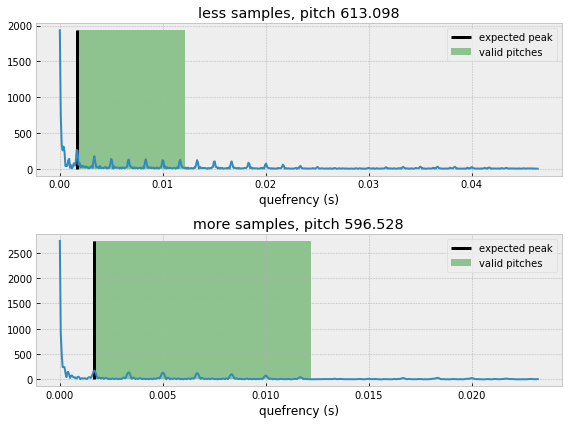

In [12]:
low_sample_freq = make_harmonic_wave(600, sample_freq, frame_size)
high_sample_freq = make_harmonic_wave(600, 2 * sample_freq, frame_size)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6))
ax1.set_title(f'less samples, pitch {cepstrum_f0_detection(low_sample_freq, sample_freq):.3f}')
ax2.set_title(f'more samples, pitch {cepstrum_f0_detection(high_sample_freq, 2*sample_freq):.3f}')
plot_cepstrum(less_samples, sample_freq, 600, ax=ax1)
plot_cepstrum(high_sample_freq, 2 * sample_freq, 600, ax=ax2)
plt.tight_layout()

Indeed, sampling at a higher frequency allows a larger valid pitch region and gives better results. We can do the simple study we did before again with this in mind.

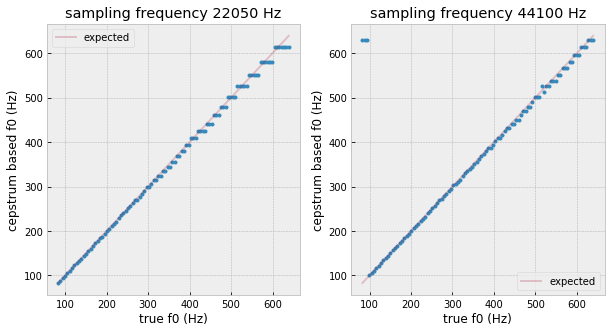

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
for ax, sample_freq_var in zip([ax1, ax2], 
                               [sample_freq, 2 * sample_freq]):
    f0s = np.linspace(83, 639, num=100)
    cepstrum_f0s = []
    for f0 in f0s:
        signal = make_harmonic_wave(f0, sample_freq_var, frame_size, n_harmonics=10)
        cepstrum_f0s.append(cepstrum_f0_detection(signal, sample_freq_var))
    ax.plot(f0s, cepstrum_f0s, '.')
    ax.plot(f0s, f0s, label='expected', alpha=.2)
    ax.legend()
    ax.set_xlabel('true f0 (Hz)')
    ax.set_ylabel('cepstrum based f0 (Hz)')
    ax.set_title(f'sampling frequency {sample_freq_var} Hz')

As can be seen above, the "staircase" effect is still there for higher frequencies, but later, and some low frequencies are now failing the detection. It seems that (as often in DSP) everything is about tradeoffs. This sort of benchmark also highlights the fact that maybe a better way of using the algorithm would be to use it as an initial estimate for a more precise f0 estimator.

That's it! I hope you've had fun following along while I tried to find my way round cepstral analysis for pitch tracking. I'm now going back to my project and will try to integrate this algorithm into my pitch tracker.

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20191025_CepstrumTutorial.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20191025_CepstrumTutorial.ipynb).*